In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import xgboost as xgb

In [3]:
re.__version__

'2.2.1'

In [4]:
#load the dataset
data = pd.read_csv(r'/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv',delimiter = '\t' , quoting = 3)
data.shape

(3150, 5)

In [5]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [6]:
data.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1
3149,4,29-Jul-18,Black Dot,Good,1


In [7]:
#Columns Names
print(f"feature Name : {data.columns.values}")

feature Name : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [8]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [9]:
data[data["verified_reviews"].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [10]:
data.dropna(inplace=True)

In [11]:
print(f" Data set shape after removing null value : {data.shape}")

 Data set shape after removing null value : (3149, 5)


In [12]:
# creating new column 'length' that will contain the length of the review
data['length'] = data["verified_reviews"].apply(len)

In [13]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [14]:
# Randomly checking for 10th record
print(f"Review : {data.iloc[15]['verified_reviews']}") # original review
print(f"original length : {len(data.iloc[15]['verified_reviews'])}")
print(f"Predicted length : {data['length'].iloc[15]}")

Review : "I love it, wife hates it."
original length : 27
Predicted length : 27


we can see our original length is same as our prediction ie, our length columns is working fine .

Datatypes of features

In [15]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

* rating , feedback is of integer data type
* date , variation , verified_reviews is of object data type

In [16]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

# Data Visualization

## 1. Rating Columns

In [17]:
#Distinct Vlaue of Rating and its count
print(f"Rating value count >>>>>>>>>>>>\n {data['rating'].value_counts()}")

Rating value count >>>>>>>>>>>>
 rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


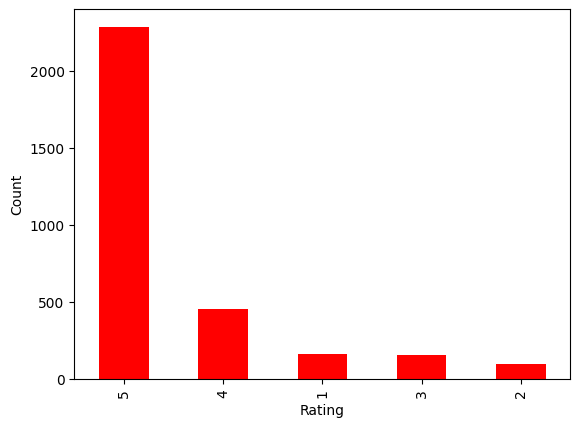

In [18]:

data['rating'].value_counts().plot.bar(color = 'red')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [19]:
print(f"{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


<Axes: ylabel='percentage wise distribution of rating'>

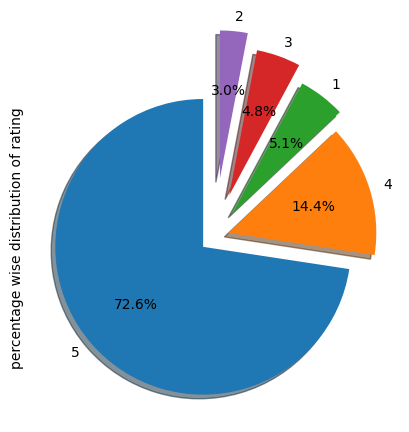

In [20]:
tags = data['rating'].value_counts()/data.shape[0]
wp = {'linewidth' : 1 , "edgecolor" : 'black'}
tags.plot(kind = "pie" , autopct = "%1.1f%%",shadow = True , startangle = 90 ,explode = (0.1,0.1,0.2,0.3,0.4) , label = "percentage wise distribution of rating")

## 2. Analyzing Feedback

In [21]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [22]:
data['feedback'].unique()

array([1, 0])

In [23]:
# here we have two value for feedback as 0 or 1
# now lets analyis what this 0 or 1 means
print(f"Review of feedback = 0 :{data[data['feedback']==0]['verified_reviews'].iloc[1]}")

Review of feedback = 0 :Sound is terrible if u want good music too get a bose


In [24]:
print(f"Review of feedback = 1 :{data[data['feedback']==1]['verified_reviews'].iloc[1]}")

Review of feedback = 1 :Loved it!


**This Implies Feedback gives :**

1-Positive Review

0-Negative Review

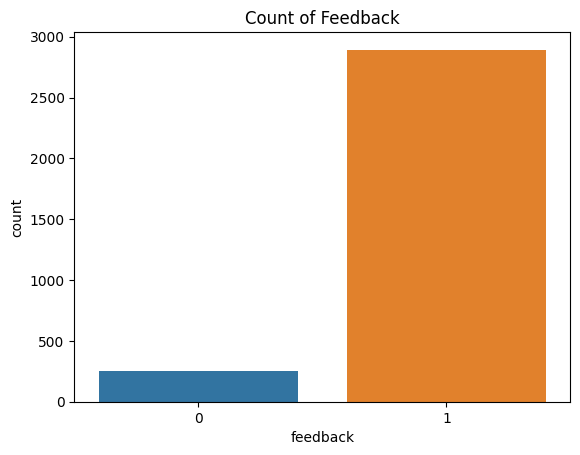

In [25]:
sns.countplot(data=data , x = 'feedback')
plt.title('Count of Feedback')
plt.xlabel('feedback')
plt.ylabel('count')
plt.show()

## 3. Variation Column

In [26]:
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

<Axes: xlabel='variation'>

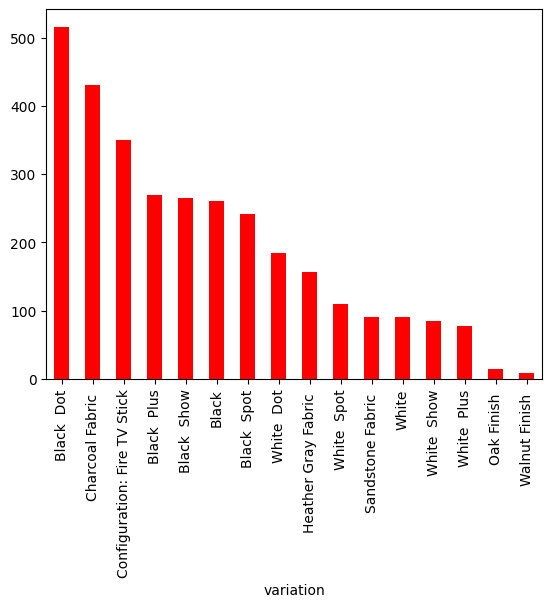

In [27]:
data['variation'].value_counts().plot.bar(color = 'r')

In [28]:
print(f"Percentage Distribution  : {data['variation'].value_counts()/data.shape[0]*100}")

Percentage Distribution  : variation
Black  Dot                      16.386154
Charcoal Fabric                 13.655129
Configuration: Fire TV Stick    11.114640
Black  Plus                      8.574151
Black  Show                      8.415370
Black                            8.288346
Black  Spot                      7.653223
White  Dot                       5.843125
Heather Gray Fabric              4.985710
White  Spot                      3.461416
Sandstone Fabric                 2.858050
White                            2.858050
White  Show                      2.699270
White  Plus                      2.476977
Oak Finish                       0.444586
Walnut Finish                    0.285805
Name: count, dtype: float64


In [29]:
data.groupby('variation')['rating'].mean().sort_values()

variation
White                           4.166667
Black                           4.233716
White  Show                     4.282353
Black  Spot                     4.311203
White  Spot                     4.311927
Sandstone Fabric                4.355556
White  Plus                     4.358974
Black  Plus                     4.370370
White  Dot                      4.423913
Black  Dot                      4.453488
Black  Show                     4.490566
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Charcoal Fabric                 4.730233
Oak Finish                      4.857143
Walnut Finish                   4.888889
Name: rating, dtype: float64

Text(0, 0.5, 'Rating')

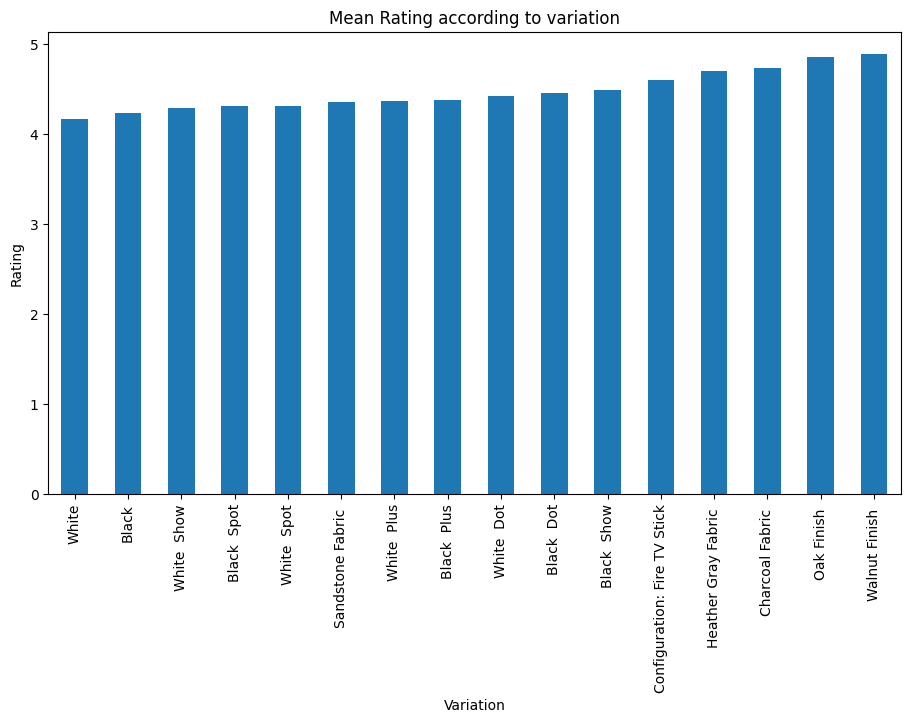

In [30]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(figsize=(11,6))
plt.title("Mean Rating according to variation")
plt.xlabel("Variation")
plt.ylabel("Rating")

## 4. Analysis Length Column

In [31]:
data.length.describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of reviews')]

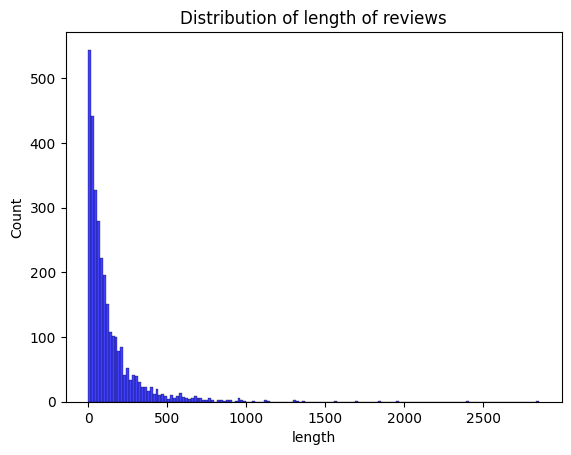

In [32]:
sns.histplot(data.length,color = 'blue').set(title = 'Distribution of length of reviews')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of reviews where feedcback is 0')]

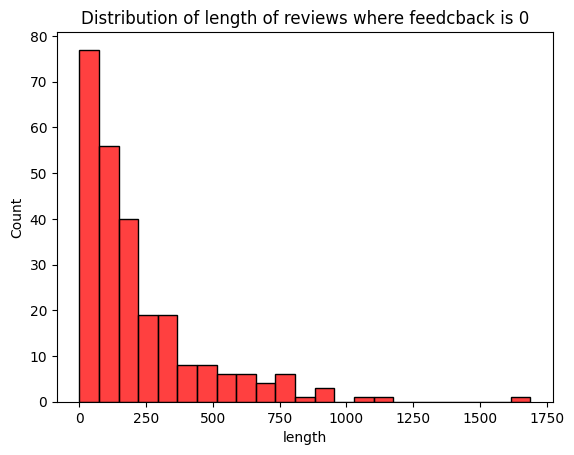

In [33]:
sns.histplot(data[data.feedback==0].length,color = 'red').set(title = 'Distribution of length of reviews where feedcback is 0')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of reviews where feedcback is 1')]

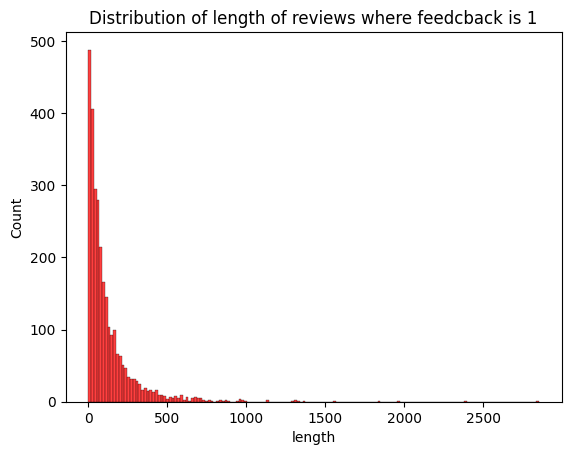

In [34]:
sns.histplot(data[data.feedback==1].length,color = 'red').set(title = 'Distribution of length of reviews where feedcback is 1')

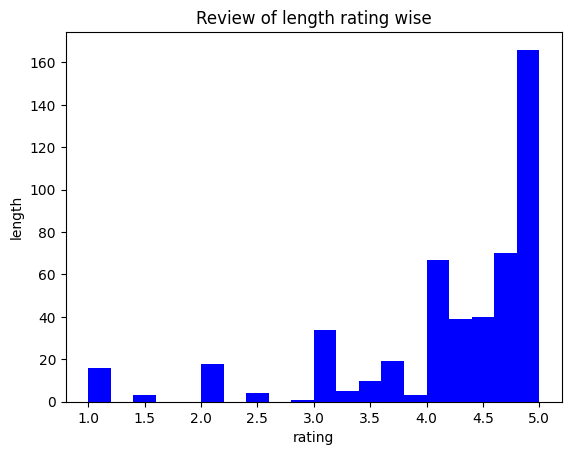

In [35]:
data.groupby('length')['rating'].mean().plot.hist(color='blue',bins = 20)
plt.title('Review of length rating wise')
plt.xlabel('rating')
plt.ylabel('length')
plt.show()

In [36]:
'''
cv = CountVectorizer(stop_words = 'english')
words  =cv.fit_transform(data.verified_reviews)'''

"\ncv = CountVectorizer(stop_words = 'english')\nwords  =cv.fit_transform(data.verified_reviews)"

## 5.WordCloud

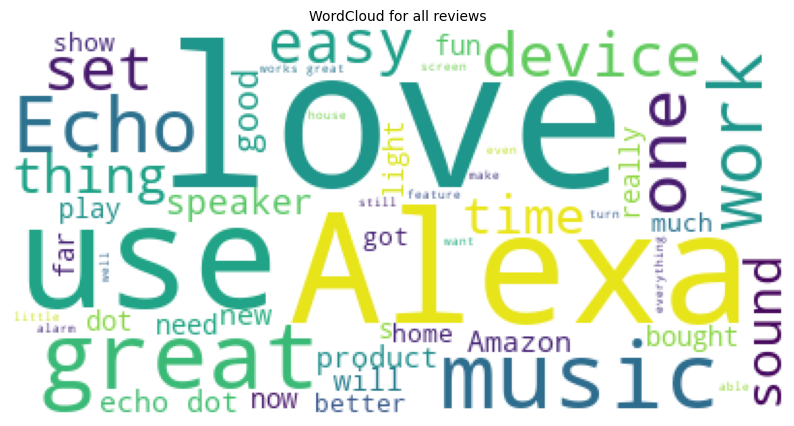

In [37]:
# join all reviews
reviews = "".join([review for review in data.verified_reviews])

# Intialize wordcloud object
wc = WordCloud(background_color = 'white',max_words = 50)

#Generate and plot wordcloud
plt.figure(figsize =(10,10))
plt.imshow(wc.generate(reviews))
plt.title('WordCloud for all reviews',fontsize = 10)
plt.axis('off')
plt.show()

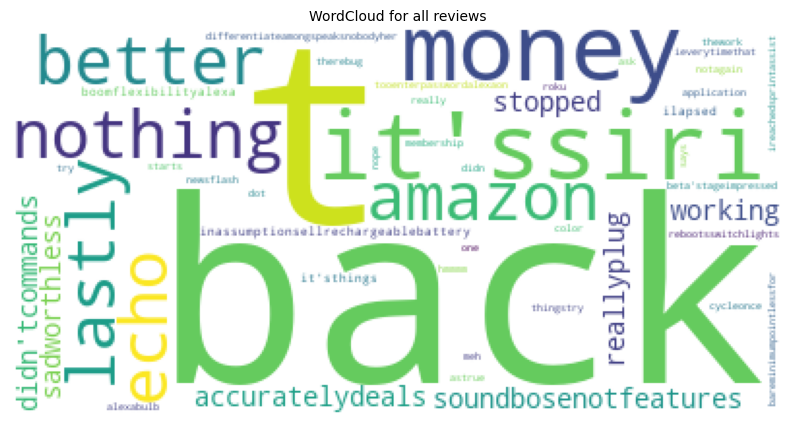

In [38]:
# join all reviews
neg_reviews = "".join([review for review in data[data.feedback == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = "".join([review for review in data[data.feedback == 1].verified_reviews])
pos_reviews = pos_reviews.lower().split()

# Finding word from reviews which are present in that feedback category only
unique_neg = [x for x in neg_reviews if x not in pos_reviews]
unique_neg = "".join(unique_neg)
unique_pos = [x for x in pos_reviews if x not in neg_reviews]
unique_pos = "".join(unique_pos)

# Intialize wordcloud object
wc = WordCloud(background_color = 'white',max_words = 50)

#Generate and plot wordcloud
plt.figure(figsize =(10,10))
plt.imshow(wc.generate(unique_neg))
plt.title('WordCloud for all reviews',fontsize = 10)
plt.axis('off')
plt.show()

> **negative words can be seen above - 'back' ,'nothing','stopped','lastly','money'**

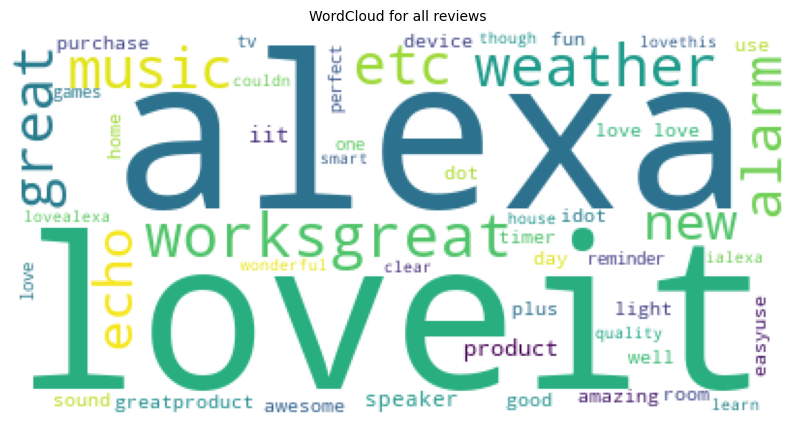

In [39]:
#Generate and plot wordcloud
plt.figure(figsize =(10,10))
plt.imshow(wc.generate(unique_pos))
plt.title('WordCloud for all reviews',fontsize = 10)
plt.axis('off')
plt.show()

> **good words can be seen from above - 'loveit','alexa','new','amazing','awesome',etc.**

# Data Preparation 

## Preprocessing

To build the corpus from the 'verified_reviews' we perform the following :

* Replace any non alphabet character with a space 
* Convert to lower case and split into words
* iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [40]:
corpus =[]
stemmer = PorterStemmer()
for i in  range(0,data.shape[0]) :
    review = re.sub('^a-zA-Z',' ',data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

## Train-Test Split

In [41]:
X = corpus
y = data['feedback']
X_train, X_test, y_train, y_test  = train_test_split(X ,y,test_size =0.2 , stratify=y, random_state = 15)

## Feature Extraction

In [42]:
cv = CountVectorizer(max_features=5000)

#storing independent and dependent variable in X and y
X_train_Vec = cv.fit_transform(X_train).toarray()
X_test_Vec = cv.transform(X_test).toarray()

In [43]:
len(y_train)

2519

In [44]:
print("shape of X_train_Vec : ", X_train_Vec.shape, "shape of y_train :", len(y_train))
print('-'*50)
print("shape of X_test_Vec : ",X_test_Vec.shape,"shape of y_test : ",len(y_test))

shape of X_train_Vec :  (2519, 3346) shape of y_train : 2519
--------------------------------------------------
shape of X_test_Vec :  (630, 3346) shape of y_test :  630


## Feature Scaling

In [45]:
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train_Vec)
X_test_scale = scaler.transform(X_test_Vec)

In [46]:
X_train_scale

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Model Training

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(y_true, y_pred, y_proba=None):
    """
    Evaluates the classification model using F1, Precision, Recall and ROC AUC.
    
    Parameters:
    - y_true: Actual labels
    - y_pred: Predicted labels
    - y_proba: Predicted probabilities (required for ROC AUC)
    """
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(" Model Evaluation:")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        print(f"ROC AUC   : {roc_auc:.4f}")
    else:
        print("ROC AUC   : Skipped (No probability scores provided)")
    print("=" * 40)

In [48]:
def model_training(X_train, y_train, X_test, y_test):
    models = {
        "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
        "Random Forest": RandomForestClassifier(class_weight='balanced'),
        "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
        "SVM (Linear)": SVC(kernel='linear', class_weight='balanced', probability=True),
        "XGBoost": XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), use_label_encoder=False, eval_metric='logloss'),
        "LightGBM": LGBMClassifier(class_weight='balanced'),
        "Multinomial NB": MultinomialNB()
    }

    for name, model in models.items():
        print(f" Model : {name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Only get probabilities if available (e.g., for ROC AUC)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test)
        else:
            y_proba = None
        
        evaluate_model(y_test, y_pred, y_proba)


In [49]:
X_test_scale

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
model_training(X_train_scale, y_train, X_test_scale, y_test)

 Model : Logistic Regression
 Model Evaluation:
Precision : 0.9584
Recall    : 0.9551
F1 Score  : 0.9567
ROC AUC   : 0.9206
 Model : Random Forest
 Model Evaluation:
Precision : 0.9425
Recall    : 0.9620
F1 Score  : 0.9521
ROC AUC   : 0.9073
 Model : Decision Tree
 Model Evaluation:
Precision : 0.9544
Recall    : 0.9033
F1 Score  : 0.9281
ROC AUC   : 0.7086
 Model : SVM (Linear)
 Model Evaluation:
Precision : 0.9559
Recall    : 0.9724
F1 Score  : 0.9640
ROC AUC   : 0.8828
 Model : XGBoost
 Model Evaluation:
Precision : 0.9687
Recall    : 0.8014
F1 Score  : 0.8771
ROC AUC   : 0.8508
 Model : LightGBM
[LightGBM] [Info] Number of positive: 2314, number of negative: 205
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 2519, nu

# Hyperparameter tunning
## Top 3 model are SVM, Logistic Regression, Xgboost

## Without Smote Data

In [52]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ------------------- Logistic Regression -------------------
print(" Tuning Logistic Regression...")
log_reg_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear'],  # works well with small datasets and class_weight
    'penalty': ['l2']
}

log_reg_grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    log_reg_params,
    scoring='f1',
    cv=folds,
    n_jobs=-1
)

log_reg_grid.fit(X_train_scale, y_train)
print(" Best Logistic Regression Params:", log_reg_grid.best_params_)

# ------------------- SVM (Linear) -------------------
print("\n Tuning Linear SVM...")
svm_params = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear']
}

svm_grid = GridSearchCV(
    SVC(class_weight='balanced', probability=True, random_state=42),
    svm_params,
    scoring='f1',
    cv=folds,
    n_jobs=-1
)

svm_grid.fit(X_train_scale, y_train)
print(" Best SVM Params:", svm_grid.best_params_)

# ------------------- XGBoost -------------------
print("\n Tuning XGBoost...")
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'scale_pos_weight': [1, 3, 5]  # Try higher if imbalance is severe
}

xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    xgb_params,
    scoring='f1',
    cv=folds,
    n_jobs=-1
)

xgb_grid.fit(X_train_scale, y_train)
print(" Best XGBoost Params:", xgb_grid.best_params_)


 Tuning Logistic Regression...
 Best Logistic Regression Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

 Tuning Linear SVM...
 Best SVM Params: {'C': 1, 'kernel': 'linear'}

 Tuning XGBoost...
 Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1}


In [53]:
from sklearn.metrics import classification_report

models = {
    "Logistic Regression": log_reg_grid.best_estimator_,
    "SVM (Linear)": svm_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_
}

for name, model in models.items():
    print(f"\n {name} Classification Report:")
    y_pred = model.predict(X_test_scale)
    print(classification_report(y_test, y_pred, digits=4))



 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.5094    0.5294    0.5192        51
           1     0.9584    0.9551    0.9567       579

    accuracy                         0.9206       630
   macro avg     0.7339    0.7423    0.7380       630
weighted avg     0.9221    0.9206    0.9213       630


 SVM (Linear) Classification Report:
              precision    recall  f1-score   support

           0     0.6098    0.4902    0.5435        51
           1     0.9559    0.9724    0.9640       579

    accuracy                         0.9333       630
   macro avg     0.7828    0.7313    0.7538       630
weighted avg     0.9278    0.9333    0.9300       630


 XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.2745    0.3889        51
           1     0.9392    0.9879    0.9630       579

    accuracy                         0.9302       630
   macro avg


## With Smote Data


In [54]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_scale, y_train)

In [55]:
#Hyperparameter Using Smote trained data
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ------------------- Logistic Regression -------------------
print(" Tuning Logistic Regression...")
log_reg_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear'],  # works well with small datasets and class_weight
    'penalty': ['l2']
}

log_reg_grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    log_reg_params,
    scoring='f1',
    cv=folds,
    n_jobs=-1
)

log_reg_grid.fit(X_train_sm, y_train_sm)
print(" Best Logistic Regression Params:", log_reg_grid.best_params_)

# ------------------- SVM (Linear) -------------------
print("\n Tuning Linear SVM...")
svm_params = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear']
}

svm_grid = GridSearchCV(
    SVC(class_weight='balanced', probability=True, random_state=42),
    svm_params,
    scoring='f1',
    cv=folds,
    n_jobs=-1
)

svm_grid.fit(X_train_sm, y_train_sm)
print(" Best SVM Params:", svm_grid.best_params_)

# ------------------- XGBoost -------------------
print("\n Tuning XGBoost...")
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'scale_pos_weight': [1, 3, 5]  # Try higher if imbalance is severe
}

xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    xgb_params,
    scoring='f1',
    cv=folds,
    n_jobs=-1
)

xgb_grid.fit(X_train_sm, y_train_sm)
print(" Best XGBoost Params:", xgb_grid.best_params_)


 Tuning Logistic Regression...
 Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

 Tuning Linear SVM...
 Best SVM Params: {'C': 10, 'kernel': 'linear'}

 Tuning XGBoost...
 Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1}


In [56]:
from sklearn.metrics import classification_report

models = {
    "Logistic Regression": log_reg_grid.best_estimator_,
    "SVM (Linear)": svm_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_
}

for name, model in models.items():
    print(f"\n {name} Classification Report:")
    y_pred = model.predict(X_test_scale)
    print(classification_report(y_test, y_pred, digits=4))



 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.4149    0.7647    0.5379        51
           1     0.9776    0.9050    0.9399       579

    accuracy                         0.8937       630
   macro avg     0.6963    0.8349    0.7389       630
weighted avg     0.9321    0.8937    0.9074       630


 SVM (Linear) Classification Report:
              precision    recall  f1-score   support

           0     0.3647    0.6078    0.4559        51
           1     0.9633    0.9067    0.9342       579

    accuracy                         0.8825       630
   macro avg     0.6640    0.7573    0.6950       630
weighted avg     0.9148    0.8825    0.8954       630


 XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.3636    0.5490    0.4375        51
           1     0.9584    0.9154    0.9364       579

    accuracy                         0.8857       630
   macro avg

In [57]:
import pandas as pd

# model evaluation results based of reports
comparison_data = {
    "Model": [
        "Logistic Regression", "SVM (Linear)", "XGBoost",
        "Logistic Regression + SMOTE", "SVM (Linear) + SMOTE", "XGBoost + SMOTE"
    ],
    "Accuracy": [0.9206, 0.9333, 0.9302, 0.8937, 0.8825, 0.8857],
    "Precision (Class 0)": [0.5094, 0.6098, 0.6667, 0.4149, 0.3647, 0.3636],
    "Recall (Class 0)": [0.5294, 0.4902, 0.2745, 0.7647, 0.6078, 0.5490],
    "F1 Score (Class 0)": [0.5192, 0.5435, 0.3889, 0.5379, 0.4559, 0.4375],
    "F1 Score (Weighted)": [0.9213, 0.9300, 0.9165, 0.9074, 0.8954, 0.8960]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index("Model", inplace=True)
comparison_df.style.background_gradient(cmap='YlGnBu').format("{:.4f}")


,Accuracy,Precision (Class 0),Recall (Class 0),F1 Score (Class 0),F1 Score (Weighted)
Model,,,,,
Logistic Regression,0.9206,0.5094,0.5294,0.5192,0.9213
SVM (Linear),0.9333,0.6098,0.4902,0.5435,0.9300
XGBoost,0.9302,0.6667,0.2745,0.3889,0.9165
Logistic Regression + SMOTE,0.8937,0.4149,0.7647,0.5379,0.9074
SVM (Linear) + SMOTE,0.8825,0.3647,0.6078,0.4559,0.8954
XGBoost + SMOTE,0.8857,0.3636,0.5490,0.4375,0.8960


## Model Selection Conclusion


 After evaluating multiple models with and without SMOTE, I chose **Linear with SMOTE** for the final deployment.Here's why:


*  It balances overall performance with a strong **recall for the minority class (class 0 = 76.47%)**
*  It avoids severe overfitting or bias toward majority class like XGBoost
*  The **weighted F1 score (0.9074)** is quite close to the non-SMOTE models while still being fairer to both classes

*This is crucial for problems where detecting minority class is important, such as fraud detection or churn modeling.*

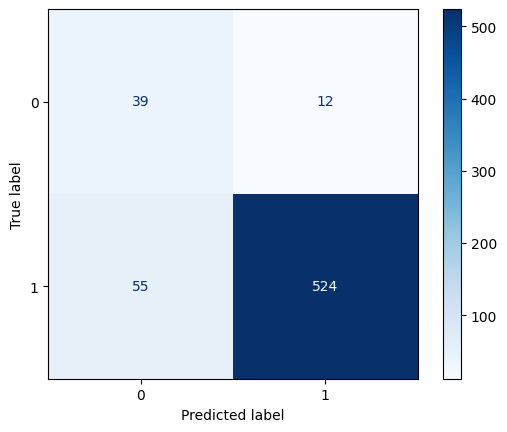

In [58]:
log_model = log_reg_grid.best_estimator_
log_model.fit(X_train_sm,y_train_sm)
y_pred_log_sm = log_model.predict(X_test_scale)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Replace y_test and y_pred_svm_smote with your actual test and predicted labels
cm = confusion_matrix(y_test, y_pred_log_sm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')


In [59]:
test_review = ["NEVER BUY CERTIFIED AND REFURBISHED ECHO"]
test_transformed = cv.transform(test_review).toarray()
test_scaled = scaler.transform(test_transformed)
test_prediction = log_model.predict(test_scaled)
print(f'model prediction : {test_prediction}')

model prediction : [0]


In [60]:
import xgboost
import sklearn
print(xgboost.__version__)
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)

2.0.3
1.26.4
2.2.2
1.2.2


In [61]:
import joblib
joblib.dump(cv,"CountVectorizer.pkl")
joblib.dump(scaler,"Scaler.pkl")
joblib.dump(log_model,"model.pkl")

['model.pkl']